Setting up Pyspark environment

In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.functions import col, avg, max, min, countDistinct, \
sum, round, current_date

In [6]:
#pyspark environment
from pyspark.sql import SparkSession

SparkSession.builder - creates an entry point to using PySpark
appName() - names the spark application
getOrCreate() - retrieves an existing spark session or creates a new one. This ensures that an application is safely created

In [7]:
#initilize the spark
spk = SparkSession.builder.appName("PySpark Mini Project")\
    .getOrCreate()

spk #printing this will also print the link to the Spark UI

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/05 15:19:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Loading the data
spark.read.csv() includes the file name to load
headers = True - file includes headers
inferSchema = True - allowing spark to automatically infer the data types of each of the columns

In [8]:
#load employee data and salary data
try:
    emp_df = spk.read.csv("employees.csv", header = True, \
                          inferSchema=True)
    print("Employees data loaded successfully")
except Exception as e:
    print("Error loading employee data",e)

Employees data loaded successfully


In [9]:
try:
    sal_df = spk.read.csv("updated_salaries.csv",header= True, \
                          inferSchema = True)
    print("Salaries loaded")
except Exception as e:
    print("Error loading Salaries data",e)    

Salaries loaded


In [10]:
emp_df.show(5)
sal_df.show(5)

+------+----------+----------+---------+------+----------+
|emp_no|birth_date|first_name|last_name|gender| hire_date|
+------+----------+----------+---------+------+----------+
| 10001|1953-09-02|    Georgi|  Facello|     M|1986-06-26|
| 10002|1964-06-02|   Bezalel|   Simmel|     F|1985-11-21|
| 10003|1959-12-03|     Parto|  Bamford|     M|1986-08-28|
| 10004|1954-05-01| Chirstian|  Koblick|     M|1986-12-01|
| 10005|1955-01-21|   Kyoichi| Maliniak|     M|1989-09-12|
+------+----------+----------+---------+------+----------+
only showing top 5 rows

+------+------+-------+----------+----------+
|emp_no|salary|dept_no| from_date|   to_date|
+------+------+-------+----------+----------+
| 10017| 71380|   d001|1993-08-03|1994-08-03|
| 10017| 75538|   d001|1994-08-03|1995-08-03|
| 10017| 79510|   d001|1995-08-03|1996-08-02|
| 10017| 82163|   d001|1996-08-02|1997-08-02|
| 10017| 86157|   d001|1997-08-02|1998-08-02|
+------+------+-------+----------+----------+
only showing top 5 rows



View Schema using printSchema()

In [11]:
emp_df.printSchema()
sal_df.printSchema()

root
 |-- emp_no: integer (nullable = true)
 |-- birth_date: date (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- hire_date: date (nullable = true)

root
 |-- emp_no: integer (nullable = true)
 |-- salary: integer (nullable = true)
 |-- dept_no: string (nullable = true)
 |-- from_date: date (nullable = true)
 |-- to_date: date (nullable = true)



Clean and Preprocess the data

In [12]:
#employee number is integer, performing arithmetic
#operations is not meaningful, so convert it to string
#convert date column to data datatype

#withColumn("new_column_name",df["existing_column"].cast("datatype"))

emp_df = emp_df.withColumn("emp_no",emp_df["emp_no"].cast("string"))


sal_df = sal_df.withColumn("emp_no",sal_df["emp_no"].cast("string"))\
            .withColumn("from_date",sal_df["from_date"].cast("date"))\
            .withColumn("to_date",sal_df["to_date"].cast("date"))


emp_df.printSchema()
sal_df.printSchema()

root
 |-- emp_no: string (nullable = true)
 |-- birth_date: date (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- hire_date: date (nullable = true)

root
 |-- emp_no: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- dept_no: string (nullable = true)
 |-- from_date: date (nullable = true)
 |-- to_date: date (nullable = true)



Exploring the Data

In [13]:
#check missing values

sal_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in sal_df.columns]).show()

25/12/05 15:19:58 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------+------+-------+---------+-------+
|emp_no|salary|dept_no|from_date|to_date|
+------+------+-------+---------+-------+
|     0|     0|      0|        0|      0|
+------+------+-------+---------+-------+



In [14]:
#summary stats for salary data
sal_df.describe().show()
#Count total rows and unique employees in salary data

print("Total row in Salary Dataset: ",sal_df.count())
print("Unique Employees in Salary Dataset: ",\
      sal_df.select("emp_no").distinct().count())


+-------+------------------+------------------+-------+
|summary|            emp_no|            salary|dept_no|
+-------+------------------+------------------+-------+
|  count|           1048575|           1048575|1048575|
|   mean|61678.835847698065| 63865.59273680948|   NULL|
| stddev| 33649.23971333684|16950.036684461244|   NULL|
|    min|            100000|             38735|   d001|
|    max|             99999|            158220|   d009|
+-------+------------------+------------------+-------+

Total row in Salary Dataset:  1048575


Unique Employees in Salary Dataset:  100412


Converting Spark Dataframe to Pandas Dataframe to use Seaborn to build a histogram using toPandas()

In [15]:
#plot salary distribution
sal_df_pandas = sal_df.toPandas()

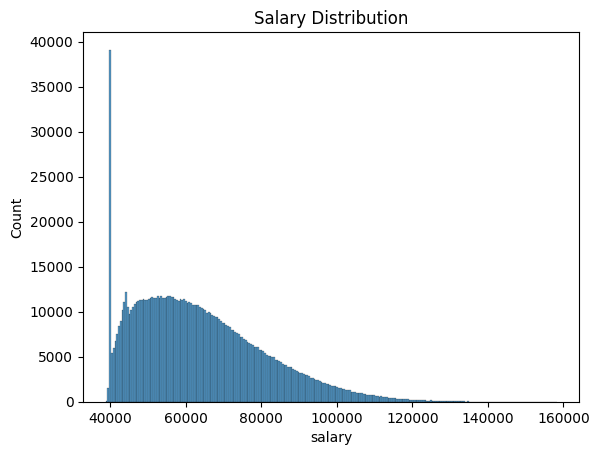

In [16]:
sns.histplot(sal_df_pandas["salary"])
plt.title("Salary Distribution")
plt.show()

Exploring Data for Employees Dataset

In [17]:
#find missing values, if any, in employees data
emp_df.select([sum(col(c).isNull().cast("int")).alias (c) for c in emp_df.columns]).show() 

+------+----------+----------+---------+------+---------+
|emp_no|birth_date|first_name|last_name|gender|hire_date|
+------+----------+----------+---------+------+---------+
|     0|         0|         0|        0|     0|        0|
+------+----------+----------+---------+------+---------+



In [18]:
## Count the number of rows in the employees data
print("Total rows in Employee Data: ",emp_df.count())

## How many different first names can be found in the employees data?
print("Different first names in employee data set: ",emp_df.select("first_name").distinct().count())

Total rows in Employee Data:  300024


Different first names in employee data set:  1275


Aggregate and Summarize the data

In [19]:
#Find the Avg salary per dept, max salary, and number of unique employees

sal_df.groupBy("dept_no").agg(
    round(avg("salary"),2).alias("avg_salary"),
    max("salary").alias("max_salary"),
    countDistinct("emp_no").alias("Employee Count")

).show()


+-------+----------+----------+--------------+
|dept_no|avg_salary|max_salary|Employee Count|
+-------+----------+----------+--------------+
|   d005|  59503.57|    144434|         29085|
|   d009|  58678.99|    144866|          5910|
|   d003|  55353.52|    123674|          6104|
|   d001|  71901.72|    143644|          6741|
|   d007|  80776.62|    158220|         17682|
|   d004|  59539.79|    132552|         25027|
|   d002|  70159.47|    134662|          5907|
|   d006|  57294.66|    122376|          6751|
|   d008|  59866.24|    124181|          7147|
+-------+----------+----------+--------------+



In [27]:
## Retrieve a list of employee numbers and the average salary.
## Make sure that you return where the average salary is more than $120,000

## Group by employee number and calculate the average salary
avg_sal = sal_df.groupBy("emp_no").agg(
    round(avg("salary"),2).alias("avg_salary"))


sal_gt_120 = avg_sal.filter(col("avg_salary") > 120000) \
                    .orderBy(col("avg_salary").desc())

## Order in descending order of average_salary

Join operations on two data sets
df1.join(df2,on = "col_name", how = "join type")

In [28]:
# calculate Age of employee from employee table
emp_df = emp_df.withColumn("Age",F.year(current_date())- F.year(col("birth_date")))

#emp_df.show(5)

#join salary and emp

emp_data = emp_df.join(sal_df,on = "emp_no",how = "left")
emp_data = emp_data.orderBy(col("emp_no"))

emp_data.show(5)




+------+----------+----------+---------+------+----------+---+------+-------+----------+----------+
|emp_no|birth_date|first_name|last_name|gender| hire_date|Age|salary|dept_no| from_date|   to_date|
+------+----------+----------+---------+------+----------+---+------+-------+----------+----------+
|100000|1956-01-11|  Hiroyasu|    Emden|     M|1991-07-02| 69| 41408|   d008|1991-07-02|1992-07-01|
|100000|1956-01-11|  Hiroyasu|    Emden|     M|1991-07-02| 69| 43119|   d008|1992-07-01|1993-07-01|
|100000|1956-01-11|  Hiroyasu|    Emden|     M|1991-07-02| 69| 46991|   d008|1993-07-01|1994-07-01|
|100000|1956-01-11|  Hiroyasu|    Emden|     M|1991-07-02| 69| 48751|   d008|1994-07-01|1995-07-01|
|100000|1956-01-11|  Hiroyasu|    Emden|     M|1991-07-02| 69| 52001|   d008|1995-07-01|1996-06-30|
+------+----------+----------+---------+------+----------+---+------+-------+----------+----------+
only showing top 5 rows



In [31]:

## Retrieve a list of employee numbers and the average salary.
## Make sure that you return where the average salary is more than $120,000



## Group by employee number and calculate the average salary


#Join the aggregated result back with the original employee data to get first_name, last_name, hire_date
emp_data_summary = sal_gt_120.join(emp_data, on = "emp_no", how = "left")\
                .select("emp_no","first_name","last_name","hire_date","Age","avg_salary")\
                .dropDuplicates(["emp_no"])\
                .orderBy(col("emp_no").desc())

emp_data_summary.show()



+------+----------+----------+----------+---+----------+
|emp_no|first_name| last_name| hire_date|Age|avg_salary|
+------+----------+----------+----------+---+----------+
| 98169|   Bedrich|      Luft|1987-01-20| 73| 134374.81|
| 96957|   Odoardo|Lindenbaum|1985-07-30| 67| 126161.06|
| 96596|      Sven|  Zallocco|1987-07-28| 68| 121171.31|
| 96407|     Hidde|    Veccia|1995-06-24| 63| 124830.25|
| 93414|      IEEE|     Biron|1990-06-03| 66| 120936.62|
| 91935|   Oldrich|      Unni|1988-01-30| 64| 129329.53|
| 91855|     Denis|      Erbe|1986-05-31| 69| 120577.25|
| 89825|    Ingmar|     Isard|1986-05-23| 73| 129105.18|
| 87965|      Mats| Arlazarov|1994-04-06| 69| 123181.38|
| 87234|   Boriana|   Mungall|1988-09-04| 71| 121810.36|
| 84659| Hyuncheol|      Zyda|1989-09-12| 68| 123353.15|
| 84147|      Huan|   Koshiba|1985-03-30| 68| 121437.06|
| 84052|      Mary|   Decleir|1985-04-29| 69| 120965.22|
| 82109|   Premsyl|    Nergos|1998-03-19| 68|  121128.0|
| 80937|   Chikako|     Jiang|1